In [86]:
import numpy as np
import pandas as pd
from gsprep.visual_tools.visual import idisplay, display
from scipy import ndimage

# Creating a baseline estimator for onset prediction based on non-contrast and perfusion CT using lesion water uptake

ischemic core defined on perfusion -> measure ischemic core lesion density (Dischemic) in NCCT
-> then measure symetry in normal tissue of the contralateral hemisphere (Dnormal).
ROIs were segmented with semi-automatic edge detection and sampled between 20 and 80 HU.

%water uptake = (1 − (Dischemic / Dnormal) × 100

In [87]:
imaging_dataset_path = '/Users/jk1/stroke_datasets/dataset_files/perfusion_data_sets/temp_split_datasets/train_with_ncct_dataset_with_onset_to_imaging_with_core_with_penumbra.npz'
label_file_path = '/Users/jk1/OneDrive - unige.ch/stroke_research/geneva_stroke_dataset/clinical_data/multi_annual_joined_data/scope_joined_variables/onset_prediction/with_imaging_curated_completed_joined_anon_outcome_df.xlsx'

id_variable = 'pid'
outcome = 'onset_to_imaging'
channels = [0,1,2,3,4,5,6]

In [88]:
ids = np.load(imaging_dataset_path, allow_pickle=True)['ids']

outcomes_df = pd.read_excel(label_file_path)
labels = np.array([outcomes_df.loc[outcomes_df[id_variable] == subj_id, outcome].iloc[0] for
                   subj_id in ids])

raw_images = np.load(imaging_dataset_path, allow_pickle=True)['ct_inputs'][..., channels]

if raw_images.ndim < 5:
    raw_images = np.expand_dims(raw_images, axis=-1)

# Apply masks
raw_masks = np.load(imaging_dataset_path, allow_pickle=True)['brain_masks']
raw_masks = np.expand_dims(raw_masks, axis=-1)
images = raw_images * raw_masks

In [89]:
n_subj = len(ids)
rCBF_over_threshold = images[..., 5]
penumbra = images[..., 6]
ncct = images[..., 4]

strict_core = rCBF_over_threshold * penumbra

In [90]:
from skimage.measure import label

def getLargestCC(segmentation):
    labels = label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segmentation.flat))
    return largestCC

Retain only largest connected component

In [91]:
cc_limited_core = [getLargestCC(strict_core[i]) for i in range(n_subj)]

Limit core to only one half of the brain

In [92]:
image_half = int(images.shape[1] / 2)
left_half_filter = np.zeros(images.shape[1:-1])
right_half_filter = np.zeros(images.shape[1:-1])
right_half_filter[0:image_half] = 1
left_half_filter[image_half:] = 1
x_center_of_mass = [ndimage.measurements.center_of_mass(strict_core[i])[0] for i in range(n_subj)]

In [93]:
laterally_limited_core = np.copy(strict_core)
for i in range(n_subj):
    # if center of core is on the left side of the image
    if x_center_of_mass[i] < image_half:
        laterally_limited_core[i] *= right_half_filter
    # if center of core is on the right side of the image
    else:
        laterally_limited_core[i] *= left_half_filter



In [94]:
mirrored_laterally_limited_core_mask = np.flip(laterally_limited_core, axis=1)



In [95]:
temp = ncct[0][np.nonzero(laterally_limited_core[0])]

In [96]:
mean_ischemic_density = [np.mean(ncct[i][np.nonzero(laterally_limited_core[i])])
                                 for i in range(n_subj)]

mean_non_ischemic_density = [np.mean(ncct[i][np.nonzero(mirrored_laterally_limited_core_mask[i])])
                                 for i in range(n_subj)]

In [97]:
water_uptake = (1 - np.divide(mean_ischemic_density, mean_non_ischemic_density)) * 100

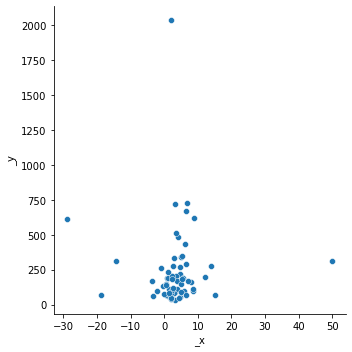

In [98]:
import seaborn as sns

sns.relplot(x=water_uptake, y=labels)

In [99]:
from sklearn import metrics

binary_labels = labels > 4.5*60

metrics.roc_auc_score(binary_labels, water_uptake)

0.6884531590413943